## BOCF-Model
The Bueno-Orovio-Cherry-Fenton-Model is a model for spatio-temporal chaos aiming at modelin excitation of heart muscle tissue. Here, we use it to generate spiral waves. Besides a certain choice of initial conditions, for spiral waves to emerge a sophisticated initialization is used, repeatedly injecting localized excitations into the system. Afterwards, the system can be simulated, and from the simulated trajectory we try to recover some of the most important of the 28 free parameters the system has.
In a second part, another, simpler system, the Aliev-Panfilov-Model is implemented. In addition to the voltage field, it posses only one instead of the BOCF-Models three gating fields. We search for parameters and initial conditions for the gating field such that the Alief-Panfilov-Model reproduces a similar dynamic to the BOCF-Model.

In [4]:
import jax.numpy as jnp
from jax import jit
from jax.scipy.signal import convolve2d
from jax.flatten_util import ravel_pytree
from jax.experimental.ode import odeint
from jax import tree_util

import numpy as np
import os
import matplotlib.pyplot as plt

from adoptODE import train_adoptODE, simple_simulation, dataset_adoptODE

### Part 1: Parameter Recovery in the BOCF Model

In [ ]:
# Defining the BOCF equations:

def define_BOCF(**kwargs_sys):
  disc_x, disc_y = kwargs_sys['disc_x'], kwargs_sys['disc_y']
  dx, dy = kwargs_sys['len_x'] / disc_x, kwargs_sys['len_y'] / disc_y
  N_sys = kwargs_sys['N_sys']

  def d_dx(f):
    return jnp.concatenate((jnp.zeros(
        (1, disc_x)), f[1:] - f[:-1], jnp.zeros((1, disc_x))),
                           axis=0)

  def d_dy(f):
    return jnp.concatenate((jnp.zeros(
        (disc_y, 1)), f[:, 1:] - f[:, :-1], jnp.zeros((disc_y, 1))),
                           axis=1)

  def gradient(f):  #gradient of scalar field
    gx = d_dx(f)
    gy = d_dy(f)
    return jnp.stack((gx, gy), axis=2)

  # stencil5 = np.array([1/4,1/2,-1.5,1/2,1/4])
  # distr5 = np.array([0.05,0.1,0.7,0.1,0.05])
  # kernel = np.outer(distr5, stencil5/dz**2) + np.outer(stencil5/dx**2, distr5)
  kernel = np.array([[1, 4, 1], [4, -20.0, 4], [1, 4, 1]]) / (
      dx * dy * 6)  #np.array([[0,1,0],[1,-4,1.],[0,1,0]])/(dx*dy)

  def laplace(f):  #laplace of scalar
    f_ext = jnp.concatenate((f[0:1], f, f[-1:]), axis=0)
    f_ext = jnp.concatenate((f_ext[:, 0:1], f_ext, f_ext[:, -1:]), axis=1)
    return convolve2d(f_ext, kernel, mode='valid')

  H = lambda x: jnp.heaviside(x, 0)

  missing_params = {}
  for key in kwargs_sys.keys():
    if not key in [
        'disc_x', 'disc_y', 'len_x', 'len_y', 'N_sys', 'Params_to_forget',
        'puls_amp', 'puls_size', 'puls_reps', 'puls_dist', 'puls_num'
    ] + kwargs_sys['Params_to_forget']:
      missing_params[key] = kwargs_sys[key]

  def tau_v_minus(u, ap):
    return (1 - H(u - ap['theta_v_minus'])) * ap['tau_v_minus1'] + H(
        u - ap['theta_v_minus']) * ap['tau_v_minus2']

  def tau_w_minus(u, ap):
    return ap['tau_w_minus1'] + (ap['tau_w_minus2'] - ap['tau_w_minus1']) * (
        1 + jnp.tanh(ap['k_w_minus'] * (u - ap['u_w_minus']))) / 2

  def tau_so(u, ap):
    return ap['tau_so1'] + (ap['tau_so2'] - ap['tau_so1']) * (
        1 + jnp.tanh(ap['k_so'] * (u - ap['u_so']))) / 2

  def tau_s(u, ap):
    return (1 - H(u - ap['theta_w'])
            ) * ap['tau_s1'] + H(u - ap['theta_w']) * ap['tau_s2']

  def tau_o(u, ap):
    return (1 - H(u - ap['theta_o'])
            ) * ap['tau_o1'] + H(u - ap['theta_o']) * ap['tau_o2']

  def v_inf(u, ap):
    return (1 - H(u - ap['theta_v_minus']))

  def w_inf(u, ap):
    return (1 - H(u - ap['theta_o'])) * (
        1 - u / ap['tau_w_inf']) + H(u - ap['theta_o']) * ap['w_inf_star']

  # D = kwargs_sys['D']
  u0, v0, w0, s0 = kwargs_sys['u0'], kwargs_sys['v0'], kwargs_sys[
      'w0'], kwargs_sys['s0']
  puls_amp, puls_size, puls_num, puls_dist, puls_reps = kwargs_sys[
      'puls_amp'], kwargs_sys['puls_size'], kwargs_sys['puls_num'], kwargs_sys[
          'puls_dist'], kwargs_sys['puls_reps']

  def J_fi(y, ap):
    return -(y['v'] * H(y['u'] - ap['theta_v']) * (y['u'] - ap['theta_v']) *
             (ap['u_u'] - y['u'])) / ap['tau_fi']

  def J_so(y, ap):
    return (y['u'] - ap['u_o']) * (1 - H(y['u'] - ap['theta_w'])) / tau_o(
        y['u'], ap) + H(y['u'] - ap['theta_w']) / tau_so(y['u'], ap)

  def J_si(y, ap):
    return -H(y['u'] - ap['theta_w']) * y['w'] * y['s'] / ap['tau_si']

  def du_dt(y, ap):
    return ap['D'] * laplace(y['u']) - (J_fi(y, ap) + J_so(y, ap) +
                                        J_si(y, ap))

  def dv_dt(y, ap):
    return (1 - H(y['u'] - ap['theta_v'])) * (
        v_inf(y['u'], ap) - y['v']) / tau_v_minus(
            y['u'], ap) - H(y['u'] - ap['theta_v']) * y['v'] / ap['tau_v_plus']

  def dw_dt(y, ap):
    return (1 - H(y['u'] - ap['theta_w'])) * (
        w_inf(y['u'], ap) - y['w']) / tau_w_minus(
            y['u'], ap) - H(y['u'] - ap['theta_w']) * y['w'] / ap['tau_w_plus']

  def ds_dt(y, ap):
    return (
        (1 + jnp.tanh(ap['k_s'] *
                      (y['u'] - ap['u_s']))) / 2 - y['s']) / tau_s(y['u'], ap)
                      
  def rescale_params(params):
    params_scaled = {}
    for key in params.keys():
      if kwargs_sys[key]<1:
        params_scaled[key] = params[key]
      else:
        params_scaled[key] = 10**params[key]
    return params_scaled
    	   
  
  @jit
  def eom(y, t, params, iparams, exparams):
    all_params = {**rescale_params(params), **missing_params}
    dudt = du_dt(y, all_params)
    dvdt = dv_dt(y, all_params)
    dwdt = dw_dt(y, all_params)
    dsdt = ds_dt(y, all_params)
    return {'u': dudt, 'v': dvdt, 'w': dwdt, 's': dsdt}

  @jit
  def loss(ys, params, iparams, exparams, targets):
    flat_fit = ravel_pytree(ys)[0]
    flat_target = ravel_pytree(targets)[0]
    return jnp.nanmean((flat_fit - flat_target)**2)

  def gen_params():
    params = {}
    for key in kwargs_sys['Params_to_forget']:
      if kwargs_sys[key]<1:
        params[key] = kwargs_sys[key] * (0.5 + np.random.rand())
      else:
        params[key] = np.log10(kwargs_sys[key] * (0.5 + np.random.rand()))
    return params, {}, {}

  def gen_y0():
    u = u0 * jnp.ones((disc_x, disc_y))
    v = v0 * jnp.ones((disc_x, disc_y))
    w = w0 * jnp.ones((disc_x, disc_y))
    s = s0 * jnp.ones((disc_x, disc_y))
    y = {'u': u, 'v': v, 'w': w, 's': s}

    params_true = {}
    for key in kwargs_sys['Params_to_forget']:
      if kwargs_sys[key]<1:
        params_true[key] = kwargs_sys[key]
      else:
        params_true[key] = np.log10(kwargs_sys[key])

    solver = jit(lambda y: odeint(eom,
                                  y,
                                  np.array([0.0, puls_dist]),
                                  params_true, {}, {},
                                  atol=1e-4,
                                  rtol=1e-4))
    for i in range(puls_reps):
      mask = np.zeros((disc_x, disc_y))
      pos = np.round(
          np.random.rand(puls_num, 2) *
          np.array([disc_x - puls_size - 1, disc_y - puls_size - 1
                    ])[np.newaxis]).astype(int)
      for p in pos:
        mask[p[0]:p[0] + puls_size,
             p[1]:p[1] + puls_size] = puls_amp * np.ones(
                 (puls_size, puls_size))
      y['u'] = y['u'] + mask
      sol = solver(y)
      y = tree_util.tree_map(lambda x: x[-1], sol)
    return y

  return eom, loss, gen_params, gen_y0, {}

In [6]:
# Defining standard parameters:
# This is a smaller system with adjusted parameters to allow spiral wave to occure in the smaller simulation domain.
# For the full code with larger simulation domain is at the end of this notebook.

kwargs_sys = {
    'disc_x': 100,#512
    'disc_y': 100,#512
    'len_x': 100,
    'len_y': 100,
    'N_sys': 1,
    'u_o': 0,
    'u_u': 1.58,
    'theta_v': 0.3,
    'theta_w': 0.015,
    'theta_v_minus': 0.015,
    'theta_o': 0.006,
    'tau_v_minus1': 60,
    'tau_v_minus2': 1150,
    'tau_v_plus': 1.4506,
    'tau_w_minus1': 70,
    'tau_w_minus2': 20,
    'k_w_minus': 65,
    'u_w_minus': 0.03,
    'tau_w_plus': 280,
    'tau_fi': 0.11,
    'tau_o1': 6,
    'tau_o2': 6,
    'tau_so1': 43,
    'tau_so2': 0.2,
    'k_so': 2,
    'u_so': 0.65,
    'tau_s1': 2.7342,
    'tau_s2': 3,
    'k_s': 2.0994,
    'u_s': 0.9087,
    'tau_si': 2.8723,
    'tau_w_inf': 0.07,
    'w_inf_star': 0.94,
    'u0': 0,
    'v0': 1,
    'w0': 1,
    's0': 0,
    'D': 0.1,
    'Params_to_forget': ['u_s', 'u_so', 'k_so', 'tau_so1', 'tau_si', 'k_s', 'u_u', 'theta_v', 'D', 'tau_fi'], # These are the Parameters forgotten and recovered by training!
    'puls_amp': 1.0,   #
    'puls_size': 3,    #
    'puls_reps': 30,   # These numbers define the initialization procedure
    'puls_dist': 150,  #
    'puls_num': 20     #
}

In [ ]:
# Following lines set up parameters and boundaries according to the parameters selected for training with 'Params_to_forget'
params_true = {}
lower_bound = {}
for key in kwargs_sys['Params_to_forget']:
  if kwargs_sys[key]<1:
    params_true[key] = kwargs_sys[key]
    lower_bound[key] = 0
  else:
    lower_bound[key] = -2
    params_true[key] = np.log10(kwargs_sys[key])

  

In [8]:
import ipywidgets as widgets

# Setting up simulation domain
N_times = 100
t_evals = jnp.linspace(0, 50, N_times)

# Specifying training properties
reset_every = 34
t_reset_idcs = tuple([
    reset_every * i
    for i in range(int(np.ceil((len(t_evals) - 1) / reset_every)))
])
kwargs_adoptODE = {
    'epochs': 100,
    'lr': 1e-2,
    't_reset_idcs': t_reset_idcs,
    'N_backups': 1,
    'lower_b': lower_bound,
    'atol': 1e-5,
    'rtol': 1e-5,
    'lr_decay':0.99
}

2025-03-20 10:04:05.425646: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.8.61). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [9]:
# Setting up a dataset via simulation
dataset_BOCF = simple_simulation(define_BOCF,
                            t_evals,
                            kwargs_sys,
                            kwargs_adoptODE,
                            params=params_true)

2025-03-20 10:04:45.128141: E external/xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng12{k11=2} for conv (f32[1,1,100,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,1,102,102]{3,2,1,0}, f32[1,1,3,3]{3,2,1,0}, f32[1]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":0.10000000149011612,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false} is taking a while...
2025-03-20 10:04:46.003851: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.875798712s
Trying algorithm eng12{k11=2} for conv (f32[1,1,100,100]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,1,102,102]{3,2,1,0}, f32[1,1,3,3]{3,2,1,0}, f32[1]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queu

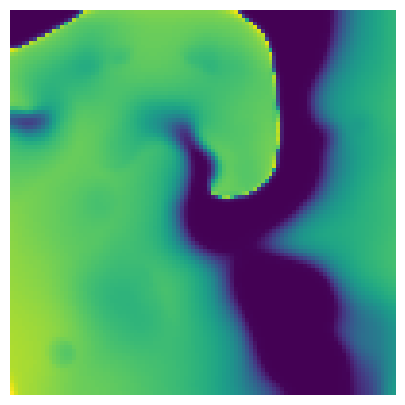

In [10]:
# Plot generated initial field
fig, ax = plt.subplots(figsize=(7,5))
ax.set_axis_off()
ax.imshow(dataset_BOCF.ys['u'][0,0])

In [11]:
def update_single_plot(frame):
    fig,axes = plt.subplots(1, 1, figsize=(6,6))

    # Plot dA_fit
    im1 = axes.matshow(dataset_BOCF.ys['u'][0,frame], cmap='coolwarm')
    # im1 = axes.matshow(dA_err[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes.set_title(f"dA error")

    # Add colorbars
    # fig.colorbar(im1, ax=axes)

    plt.show()

# Create interactive slider
frame_slider = widgets.IntSlider(min=0, max=dataset_BOCF.ys['u'][0].shape[0]-1, step=1, value=0, description="Frame")

# Use interactive_output instead of interactive
out = widgets.interactive_output(update_single_plot, {'frame': frame_slider})

# Display slider and output
display(frame_slider, out)

IntSlider(value=0, description='Frame', max=99)

Output()

In [12]:
# Performing training
params_final, losses, errors, params_history = train_adoptODE(dataset_BOCF, print_interval=10, save_interval=10)

Epoch 000:   Params Err.: 4.7e-01, y0 error: 0.0e+00, Params Norm: 2.2e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 6.2e-03, 
Epoch 010:   Params Err.: 4.5e-01, y0 error: 0.0e+00, Params Norm: 2.2e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 1.7e-03, 
Epoch 020:   Params Err.: 4.3e-01, y0 error: 0.0e+00, Params Norm: 2.2e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 1.1e-03, 
Epoch 030:   Params Err.: 4.1e-01, y0 error: 0.0e+00, Params Norm: 2.2e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 9.3e-04, 
Epoch 040:   Params Err.: 3.9e-01, y0 error: 0.0e+00, Params Norm: 2.2e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 7.2e-04, 
Epoch 050:   Params Err.: 3.8e-01, y0 error: 0.0e+00, Params Norm: 2.2e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 5.9e-04, 
Epoch 060:   Params Err.: 3.7e-01, y0 error: 0.0e+00, Params Norm: 2.2

In [13]:
# Print fitted parameter values
print('Parameter:   True Value:   Recovered Value:')
for key in dataset_BOCF.params.keys():
    print(key+(16-len(key))*' '+'{:.3f}         {:-3f}'.format(dataset_BOCF.params[key], dataset_BOCF.params_train[key]))

Parameter:   True Value:   Recovered Value:
D               0.100         0.102335
k_s             0.322         0.247984
k_so            0.301         0.435100
tau_fi          0.110         0.171434
tau_si          0.458         0.589447
tau_so1         1.633         1.550507
theta_v         0.300         0.309258
u_s             0.909         0.927104
u_so            0.650         0.885263
u_u             0.199         0.293339


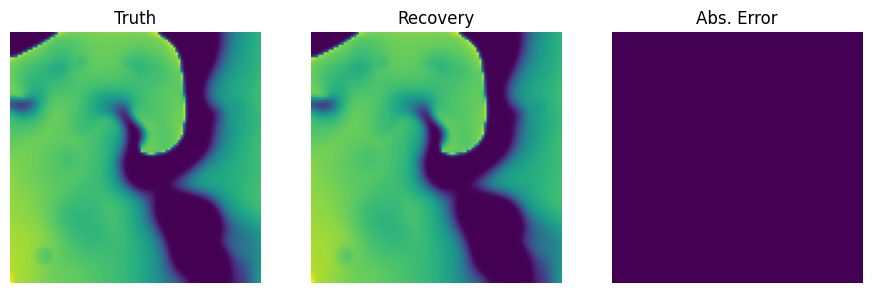

In [14]:
# Plot voltage field at last frame after training
fig, ax = plt.subplots(1,3, figsize=(11,5))
frame = 0
ax[0].imshow(dataset_BOCF.ys['u'][0,frame])
ax[0].set_axis_off()
ax[0].set_title('Truth')
ax[1].imshow(dataset_BOCF.ys_sol['u'][0,frame])
ax[1].set_axis_off()
ax[1].set_title('Recovery')
ax[2].imshow(np.abs(dataset_BOCF.ys['u'][0,frame]-dataset_BOCF.ys_sol['u'][0,frame]))
ax[2].set_axis_off()
ax[2].set_title('Abs. Error');

### Part 2: Comparison with Aliev-Panfilov-Model

In [ ]:
def define_AP(**kwargs_sys):
  disc_x, disc_y = kwargs_sys['disc_x'], kwargs_sys['disc_y']
  dx, dy = kwargs_sys['len_x'] / disc_x, kwargs_sys['len_y'] / disc_y
  N_sys = kwargs_sys['N_sys']

  def d_dx(f):
    return jnp.concatenate((jnp.zeros(
        (1, disc_x)), f[1:] - f[:-1], jnp.zeros((1, disc_x))),
                           axis=0)

  def d_dy(f):
    return jnp.concatenate((jnp.zeros(
        (disc_y, 1)), f[:, 1:] - f[:, :-1], jnp.zeros((disc_y, 1))),
                           axis=1)

  kernel = np.array([[1, 4, 1], [4, -20.0, 4], [1, 4, 1]]) / (
      dx * dy * 6)  #np.array([[0,1,0],[1,-4,1.],[0,1,0]])/(dx*dy)

  def laplace(f):  #laplace of scalar
    f_ext = jnp.concatenate((f[0:1], f, f[-1:]), axis=0)
    f_ext = jnp.concatenate((f_ext[:, 0:1], f_ext, f_ext[:, -1:]), axis=1)
    return convolve2d(f_ext, kernel, mode='valid')

  def epsilon(u,v,rp):
    return rp['eps0']+rp['mu1']*v/(u+rp['mu2'])

  def eom(y, t, params, iparams, exparams):
        p=params
        u=y['u']
        v=y['v']
        dudt = p['D']*laplace(u)-(10.0**p['logk'])*u*(u-p['a'])*(u-1) - u*v
        dvdt = epsilon(u,v,p)*(-v-(10.0**p['logk'])*u*(u-p['a']-1))
        return {'u':dudt, 'v':dvdt}
    
  def gen_params():
    return {'D':1.5,'a':0.06,'logk':1.0,'eps0':0.001,'mu1':0.2,'mu2':0.3}, {}, {}

  def loss(ys, params, iparams, exparams, targets):
    flat_fit = ys['u']
    flat_target = targets['u']
    return jnp.nanmean((flat_fit - flat_target)**2)  
        
  return eom, loss, gen_params, None, {}

In [16]:
# Use previous data to generate truth for AP model
ys_BOCF = dataset_BOCF.ys
y0 = {'u':ys_BOCF['u'][:,0], 'v':ys_BOCF['v'][:,0]}
target_ys = {'u':ys_BOCF['u'], 'v':ys_BOCF['v']}
t_evals = dataset_BOCF.t_evals/12.9 # The implementations have different timescales, BOCF is in ms while AP in a typically non-dimensionalized unit.

In [17]:
params_guess = {'D':1.17,'a':0.06,'logk':1.0,'eps0':0.001,'mu1':0.2,'mu2':0.3}
kwargs_sys = {'disc_x': 100,
            'disc_y': 100,
            'len_x': 100,
            'len_y': 100,
            'N_sys': 1}
kwargs_adoptODE = {
    'epochs': 200,
    'lr': 5e-3,
    'lr_y0':5e-3,
    'N_backups': 2,
    'atol': 1e-5,
    'rtol': 1e-5,
    'lower_b':tree_util.tree_map(lambda x: 0*x+1e-4, params_guess),
    'lower_b_y0':{'u':y0['u'], 'v':0},
    'upper_b_y0':{'u':y0['u'], 'v':10}
} # lower bound
target_ys = {'u':ys_BOCF['u'], 'v':ys_BOCF['v']}
dataset_AP = dataset_adoptODE(define_AP, target_ys, t_evals, kwargs_sys, kwargs_adoptODE, params_train = params_guess)

In [18]:
# Performing training
params_final, losses, errors, params_history = train_adoptODE(dataset_AP, print_interval=10, save_interval=10)

Epoch 000:  Loss: 1.7e-01,  Params Err.: nan, y0 error: nan, Params Norm: 1.6e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 010:  Loss: 1.5e-01,  Params Err.: nan, y0 error: nan, Params Norm: 1.6e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 020:  Loss: 1.1e-01,  Params Err.: nan, y0 error: nan, Params Norm: 1.6e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 030:  Loss: 8.0e-02,  Params Err.: nan, y0 error: nan, Params Norm: 1.6e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 040:  Loss: 6.9e-02,  Params Err.: nan, y0 error: nan, Params Norm: 1.6e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 050:  Loss: 5.9e-02,  Params Err.: nan, y0 error: nan, Params Norm: 1.7e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 060:  Loss: 5.1e-02,  Params Err.: nan, y0 error: nan, Params Norm: 1.7e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, 
Epoch 070:  Loss: 4.6e-02,  Params Err.: nan, y0 error: nan, Params Norm: 1.7e+00, iParams

Text(0.5, 1.0, 'Abs. Error')

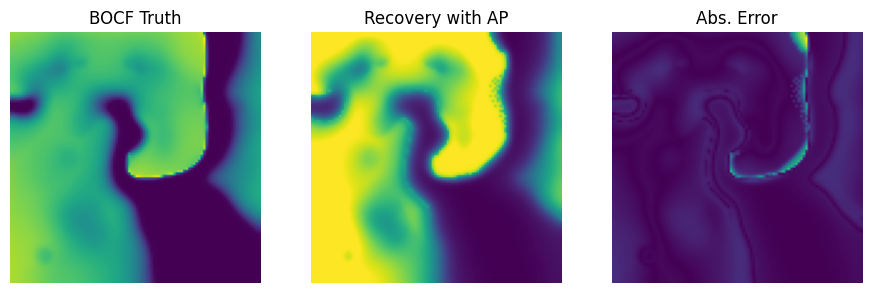

In [19]:
# Plot voltage field at last frame after training
fig, ax = plt.subplot_mosaic([[0,1,2]], figsize=(11,5))
ax[0].imshow(dataset_AP.ys['u'][0,-1])
ax[0].set_axis_off()
ax[0].set_title('BOCF Truth')
ax[1].imshow(dataset_AP.ys_sol['u'][0,-1])
ax[1].set_axis_off()
ax[1].set_title('Recovery with AP')
ax[2].imshow(np.abs(dataset_AP.ys['u'][0,-1]-dataset_AP.ys_sol['u'][0,-1]))
ax[2].set_axis_off()
ax[2].set_title('Abs. Error')

In [20]:
# Function to update the plot
def update_plot(frame):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create 2 side-by-side subplots
    
    # Plot dA_fit
    im1 = axes[0].matshow(dataset_AP.ys['u'][0,frame], cmap='coolwarm')
    # im1 = axes[0].matshow(dA_rec[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[0].set_title(f"reconstruction")
    
    # Plot dA_sim
    im2 = axes[1].matshow(dataset_AP.ys_sol['u'][0,frame], cmap='coolwarm')
    # im2 = axes[1].matshow(dA_sim[frame, pad:-pad, pad:-pad], cmap='coolwarm', vmin=vmin, vmax=vmax)
    axes[1].set_title(f"simulation")
    
    # Add colorbars
    # fig.colorbar(im1, ax=axes[0])
    # fig.colorbar(im2, ax=axes[1])

    plt.show()

# Create interactive slider
frame_slider = widgets.IntSlider(min=0, max=dataset_BOCF.ys_sol['u'][0,:].shape[0]-1, step=1, value=0, description="Frame")

# Use interactive_output instead of interactive
out = widgets.interactive_output(update_plot, {'frame': frame_slider})

# Display slider and output
display(frame_slider, out)

IntSlider(value=0, description='Frame', max=99)

Output()

### BOCF-Model on large domain:

In [ ]:
kwargs_sys = {
    'disc_x': 512,
    'disc_y': 512,
    'len_x': 512,
    'len_y': 512,
    'N_sys': 1,
    'u_o': 0,
    'u_u': 1.58,
    'theta_v': 0.3,
    'theta_w': 0.015,
    'theta_v_minus': 0.015,
    'theta_o': 0.006,
    'tau_v_minus1': 60,
    'tau_v_minus2': 1150,
    'tau_v_plus': 1.4506,
    'tau_w_minus1': 70,
    'tau_w_minus2': 20,
    'k_w_minus': 65,
    'u_w_minus': 0.03,
    'tau_w_plus': 280,
    'tau_fi': 0.11,
    'tau_o1': 6,
    'tau_o2': 6,
    'tau_so1': 43,
    'tau_so2': 0.2,
    'k_so': 2,
    'u_so': 0.65,
    'tau_s1': 2.7342,
    'tau_s2': 3,
    'k_s': 2.0994,
    'u_s': 0.9087,
    'tau_si': 2.8723,
    'tau_w_inf': 0.07,
    'w_inf_star': 0.94,
    'u0': 0,
    'v0': 1,
    'w0': 1,
    's0': 0,
    'D': 0.2,
    'Params_to_forget': ['u_s', 'u_so', 'k_so', 'tau_so1', 'tau_si', 'k_s', 'u_u', 'theta_v', 'D', 'tau_fi'],
    'puls_amp': 1.0,
    'puls_size': 5,
    'puls_reps': 30,
    'puls_dist': 150,
    'puls_num': 50
}

params_true = {}
lower_bound = {}
for key in kwargs_sys['Params_to_forget']:
  if kwargs_sys[key]<1:
    params_true[key] = kwargs_sys[key]
    lower_bound[key] = 0
  else:
    lower_bound[key] = -2
    params_true[key] = np.log10(kwargs_sys[key])

N_times = 100
t_evals = jnp.linspace(0, 50, N_times)
reset_every = 34
t_reset_idcs = tuple([
    reset_every * i
    for i in range(int(np.ceil((len(t_evals) - 1) / reset_every)))
])

kwargs_adoptODE = {
    'epochs': 10001,
    'lr': 3e-3,
    't_reset_idcs': t_reset_idcs,
    'N_backups': 1,
    'lower_b': lower_bound,
    'atol': 1e-6,
    'rtol': 1e-6,
    'lr_decay': 1.0
}

dataset_BOCF = simple_simulation(define_BOCF,
                            t_evals,
                            kwargs_sys,
                            kwargs_adoptODE,
                            params=params_true)

# Plot generated initial field
fig, ax = plt.subplots(figsize=(7,5))
ax.set_axis_off()
ax.imshow(dataset_BOCF.ys['v'][0,0])
ax.set_title('Initial voltage field')

params_final, losses, errors, params_history = train_adoptODE(dataset_BOCF, print_interval=200)

Epoch 000:   Params Err.: 3.7e-01, y0 error: 0.0e+00, Params Norm: 1.9e+00, iParams Err.: 0.0e+00, iParams Norm: 0.0e+00, Stopped/Resetted Loss: 5.7e-03, 


In [ ]:
# Print fitted parameter values
print('Parameter:   True Value:   Recovered Value:')
for key in dataset_BOCF.params.keys():
    print(key+(16-len(key))*' '+'{:.3f}         {:-3f}'.format(dataset_BOCF.params[key], dataset_BOCF.params_train[key]))

# Plot voltage field at last frame after training
fig, ax = plt.subplots(1,3, figsize=(11,5))
ax[0].imshow(dataset_BOCF.ys['u'][0,-1])
ax[0].set_axis_off()
ax[0].set_title('Truth')
ax[1].imshow(dataset_BOCF.ys_sol['u'][0,-1])
ax[1].set_axis_off()
ax[1].set_title('Recovery')
ax[2].imshow(np.abs(dataset_BOCF.ys['u'][0,-1]-dataset_BOCF.ys_sol['u'][0,-1]))
ax[2].set_axis_off()
ax[2].set_title('Abs. Error');

### AP-Model on large domain

In [ ]:
ys_BOCF = dataset_BOCF.ys
y0 = {'u':ys_BOCF['u'][:,0], 'v':ys_BOCF['v'][:,0]}

In [ ]:
t_evals = jnp.linspace(0, 50, 100)/12.9 # The implementations have different timescales, BOCF is in ms while AP in a typically non-dimensionalized unit.
params_guess = {'D':1.17,'a':0.06,'logk':1.0,'eps0':0.001,'mu1':0.2,'mu2':0.3}
kwargs_sys = {'disc_x': 512,
            'disc_y': 512,
            'len_x': 512,
            'len_y': 512,
            'N_sys': 1}
kwargs_adoptODE = {
    'epochs': 1000,
    'lr': 5e-3,
    'lr_y0':5e-3,
    'N_backups': 1,
    'atol': 1e-6,
    'rtol': 1e-6,
    'lower_b':tree_util.tree_map(lambda x: 0*x+1e-4, params_guess),
    'lower_b_y0':{'u':y0['u'], 'v':0},
    'upper_b_y0':{'u':y0['u'], 'v':10}
} # lower bound
target_ys = {'u':ys_BOCF['u'], 'v':ys_BOCF['v']}
dataset_AP = dataset_adoptODE(define_AP, target_ys, t_evals, kwargs_sys, kwargs_adoptODE, params_train = params_guess)

params_final, losses, errors, params_history = train_adoptODE(dataset_AP, print_interval=10, save_interval=10)

In [ ]:
# Plot voltage field at last frame after training
fig, ax = plt.subplot_mosaic([[0,1,2]], figsize=(11,5))
ax[0].imshow(dataset_AP.ys['u'][0,-1])
ax[0].set_axis_off()
ax[0].set_title('BOCF Truth')
ax[1].imshow(dataset_AP.ys_sol['u'][0,-1])
ax[1].set_axis_off()
ax[1].set_title('Recovery with AP')
ax[2].imshow(np.abs(dataset_AP.ys['u'][0,-1]-dataset_AP.ys_sol['u'][0,-1]))
ax[2].set_axis_off()
ax[2].set_title('Abs. Error')